Data acquisition and exploration

In [1]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

In [2]:
'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline

In [3]:
'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Load the MNIST datasets

In [5]:
from sklearn.datasets import fetch_openml

In [6]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)
mnist.data.shape

(70000, 784)

In [7]:
mnist.data.min(), mnist.data.max()

(0, 255)

In [8]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [9]:
X /= 255.0

In [10]:
X.min(), X.max()

(0.0, 1.0)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.14285, random_state=1)

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.16666, random_state=1)

In [13]:
# Verify shape of datasets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 784)
Shape of y_train:  (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


Create Pandas DataFrames from the datasets

In [14]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train),  len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation),  len(X_train)+
                   len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

Explore the data

In [15]:
# Describe the training matrix
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000715,0.000364,0.000146,0.000033,0.000058,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022098,0.016046,0.009365,0.003710,0.006845,0.001489,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992157,0.996078,0.988235,0.694118,0.996078,0.243137,0.0,0.0,0.0,0.0


In [16]:
# Show the labels
y_train.head()

,0
0,1
1,8
2,2
3,6
4,2


Display the images

In [17]:
def view_digit(example):
  label = y_train.loc[0]
  image = X_train.loc[example,:].values.reshape([28,28])
  plt.title('Example: %d Label: %d' % (example, label))
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.show()

PCA

In [18]:
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

Apply PCA

In [19]:
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

Evaluate PCA

In [20]:
# Percentage of Variance Captured by 784 principal components
print(f"Variance Explained by all {n_components} principal components: ", sum(pca.explained_variance_ratio_))

Variance Explained by all 784 principal components:  1.0000000928402013


In [21]:
# Percentage of Variance Captured by X principal components
importanceOfPrincipalComponents =  pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T
print('Variance Captured by First 10 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:9].sum(axis=1).values)
print('Variance Captured by First 20 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:19].sum(axis=1).values)
print('Variance Captured by First 50 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:49].sum(axis=1).values)
print('Variance Captured by First 100 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:99].sum(axis=1).values)
print('Variance Captured by First 200 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:199].sum(axis=1).values)
print('Variance Captured by First 300 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:299].sum(axis=1).values
)

Variance Captured by First 10 Principal Components:  [0.48902032]
Variance Captured by First 20 Principal Components:  [0.64476085]
Variance Captured by First 50 Principal Components:  [0.8255328]
Variance Captured by First 100 Principal Components:  [0.91507167]
Variance Captured by First 200 Principal Components:  [0.9665851]
Variance Captured by First 300 Principal Components:  [0.9863006]


A importância das 10 primeiras componentes principais

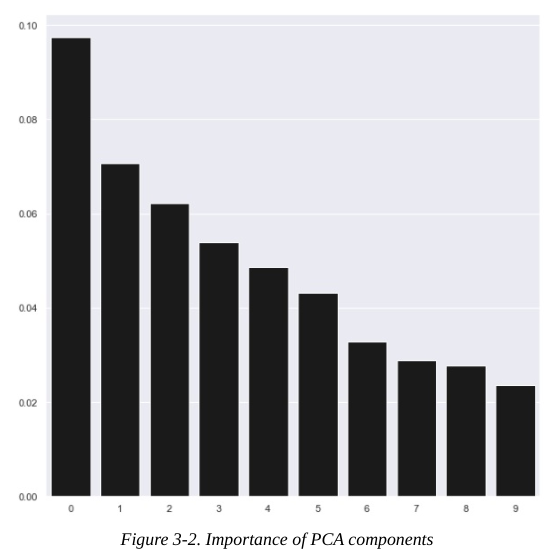

Visualize the separation of points in space

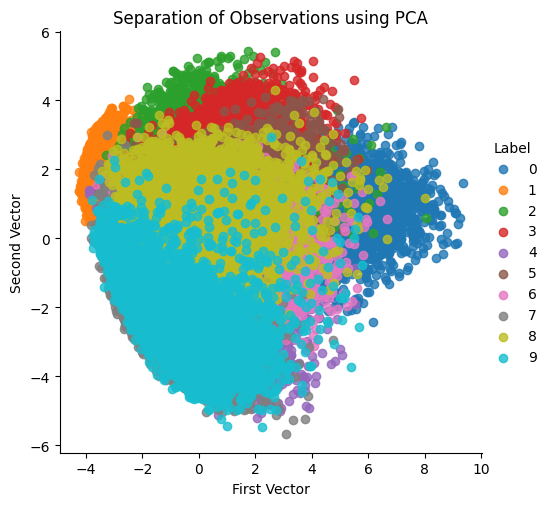

In [22]:
def scatterPlot(xDF, yDF, algoName):
  tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
  tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
  tempDF.columns = ["First Vector", "Second Vector", "Label"]
  sns.lmplot(x="First Vector", y="Second Vector",
  hue="Label",
  data=tempDF, fit_reg=False)
  ax = plt.gca()
  ax.set_title("Separation of Observations using "+algoName)

scatterPlot(X_train_PCA, y_train, "PCA")

Após um treinamento em um algoritmo supervisionado, se gerarmos o mesmo gráfico anterior com as duas características mais importantes dentre todas as 784 cacterísticas, teremos:

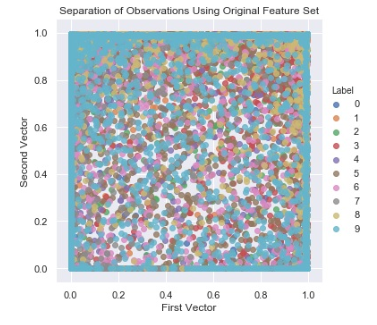

Incremental PCA

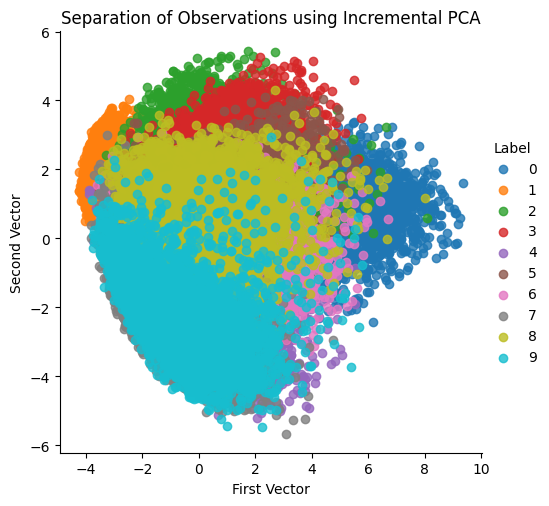

In [23]:
# Incremental PCA
from sklearn.decomposition import IncrementalPCA

n_components = 784
batch_size = None

incrementalPCA = IncrementalPCA(n_components=n_components,
                                batch_size=batch_size)
X_train_incrementalPCA = incrementalPCA.fit_transform(X_train)
X_train_incrementalPCA = pd.DataFrame(data=X_train_incrementalPCA,
                                      index=train_index)
X_validation_incrementalPCA = incrementalPCA.transform(X_validation)
X_validation_incrementalPCA = pd.DataFrame(data=X_validation_incrementalPCA,
                                           index=validation_index)
scatterPlot(X_train_incrementalPCA, y_train, "Incremental PCA")

Sparse PCA

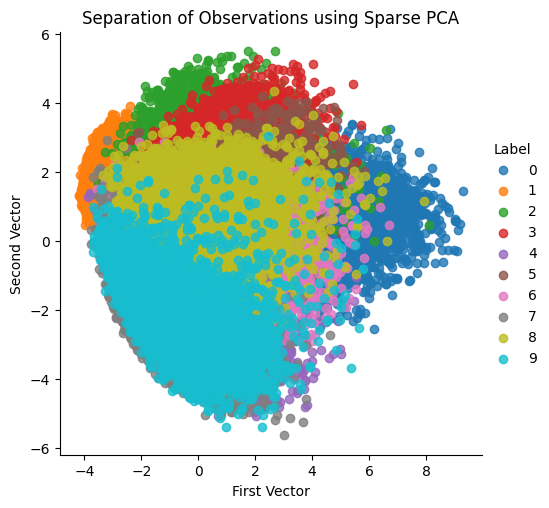

In [24]:
# Sparse PCA
from sklearn.decomposition import SparsePCA

n_components = 100
alpha = 0.0001
random_state = 2018
n_jobs = -1

sparsePCA = SparsePCA(n_components=n_components, alpha=alpha,
                      random_state=random_state, n_jobs=n_jobs)
sparsePCA.fit(X_train.loc[:10000,:])
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=train_index)
X_validation_sparsePCA = sparsePCA.transform(X_validation)
X_validation_sparsePCA = pd.DataFrame(data=X_validation_sparsePCA,
                                      index=validation_index)

scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

Kernel PCA

In [ ]:
# Kernel PCA
from sklearn.decomposition import KernelPCA

n_components = 100
kernel = 'rbf'
gamma = None
random_state = 2018
n_jobs = 1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel,
                      gamma=gamma, n_jobs=n_jobs, random_state=random_state)
kernelPCA.fit(X_train.loc[:10000,:])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA,index=train_index)

X_validation_kernelPCA = kernelPCA.transform(X_validation)
X_validation_kernelPCA = pd.DataFrame(data=X_validation_kernelPCA,
                                      index=validation_index)

scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

SVD ----------------------------------------------------------------------------

In [ ]:
# Singular Value Decomposition
from sklearn.decomposition import TruncatedSVD
n_components = 200

algorithm = 'randomized'
n_iter = 5
random_state = 2018

svd = TruncatedSVD(n_components=n_components,
algorithm=algorithm, n_iter=n_iter, random_state=random_state)

X_train_svd = svd.fit_transform(X_train)
X_train_svd = pd.DataFrame(data=X_train_svd, index=train_index)

X_validation_svd = svd.transform(X_validation)
X_validation_svd = pd.DataFrame(data=X_validation_svd, index=validation_index)

scatterPlot(X_train_svd, y_train, "Singular Value Decomposition")

t-SNE --------------------------------------------------------------------------------

In [ ]:
# t-SNE
from sklearn.manifold import TSNE

n_components = 2
learning_rate = 300
perplexity = 30
early_exaggeration = 12
init = 'random'
random_state = 2018

tSNE = TSNE(n_components=n_components, learning_rate=learning_rate,
            perplexity=perplexity, early_exaggeration=early_exaggeration,
            init=init, random_state=random_state)

X_train_tSNE = tSNE.fit_transform(X_train_PCA.loc[:5000,:9])
X_train_tSNE = pd.DataFrame(data=X_train_tSNE, index=train_index[:5001])

scatterPlot(X_train_tSNE, y_train, "t-SNE")

In [ ]:
# t-SNE
from sklearn.manifold import TSNE

n_components = 2
learning_rate = 300
perplexity = 5
early_exaggeration = 12
init = 'random'
random_state = 2018

tSNE = TSNE(n_components=n_components, learning_rate=learning_rate,
            perplexity=perplexity, early_exaggeration=early_exaggeration,
            init=init, random_state=random_state)

X_train_tSNE = tSNE.fit_transform(X_train_PCA.loc[:5000,:9])
X_train_tSNE = pd.DataFrame(data=X_train_tSNE, index=train_index[:5001])

scatterPlot(X_train_tSNE, y_train, "t-SNE")

In [ ]:
# t-SNE
from sklearn.manifold import TSNE

n_components = 2
learning_rate = 300
perplexity = 50
early_exaggeration = 12
init = 'random'
random_state = 2018

tSNE = TSNE(n_components=n_components, learning_rate=learning_rate,
            perplexity=perplexity, early_exaggeration=early_exaggeration,
            init=init, random_state=random_state)

X_train_tSNE = tSNE.fit_transform(X_train_PCA.loc[:5000,:9])
X_train_tSNE = pd.DataFrame(data=X_train_tSNE, index=train_index[:5001])

scatterPlot(X_train_tSNE, y_train, "t-SNE")